## Import packages

In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.19.0


## Visualization Utility Functions

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Mount Google Drive to Colab Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Deep-learning/A3')

### Load AG News Subset Data
<div class="alert alert-block alert-info">
    <b> ag_news_subset</b><br>
    See https://www.tensorflow.org/datasets/catalog/ag_news_subset
    </div>

In [ ]:
# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)
text_only_dataset_all=dataset_all.map(lambda x, y: x)

###  EDA AG News Subset

**Get information about the ag_news_subset dataset. We combined the training and test data for a total of 127,600 news articles.**

In [ ]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


### Review Labels (Categories)

In [ ]:
categories =dict(enumerate(info.features["label"].names))
print(f'Dictionary: ',categories)

Dictionary:  {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


### Review Class Balance
The 127,600 news articles are evenly distributed among the 4 categories

In [ ]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

### Preprocess Dataset for EDA

In [ ]:
@tf.keras.utils.register_keras_serializable()
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

In [ ]:
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")

### TextVectorization and Adapt() Vocabulary

In [ ]:
%%time
max_tokens = None
text_vectorization=layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_dataset_all)

CPU times: user 14min 9s, sys: 8.45 s, total: 14min 18s
Wall time: 14min


In [ ]:
%%time
doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = text_vectorization(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

CPU times: user 14min 15s, sys: 6.56 s, total: 14min 22s
Wall time: 14min 13s


In [ ]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 2579419 words in the corpus of 127600 news articles.
Each news article has between 2 and 95 tokens in it.


In [ ]:
print(f"There are {len(text_vectorization.get_vocabulary())} vocabulary words in the corpus.")

There are 95827 vocabulary words in the corpus.


In [ ]:
vocab = np.array(text_vectorization.get_vocabulary())
print(vocab[:100]) # sorted by frequency

['' '[UNK]' '39s' 'said' 'new' 'us' 'reuters' 'ap' 'two' 'first' 'monday'
 'wednesday' 'tuesday' 'thursday' 'company' 'friday' 'inc' 'one' 'world'
 'yesterday' 'last' 'york' 'year' 'president' 'million' 'oil' 'corp'
 'united' 'would' 'sunday' 'years' 'week' 'people' 'today' 'three'
 'government' 'could' 'quot' 'group' 'time' 'percent' 'game' 'saturday'
 'software' 'night' 'next' 'prices' 'iraq' 'security' 'announced'
 'minister' 'microsoft' 'season' 'team' 'second' 'internet'
 'international' 'may' 'washington' 'state' '2004' 'former' 'states' '39'
 'officials' 'back' 'market' 'day' 'says' 'billion' 'win' 'business'
 'news' 'victory' 'city' 'four' 'european' 'top' 'afp' 'technology'
 'reported' 'service' 'league' 'sales' 'federal' 'killed' 'according'
 'computer' 'national' 'record' 'home' 'prime' 'american' 'plans' 'end'
 'third' 'made' 'research' 'major' 'network']


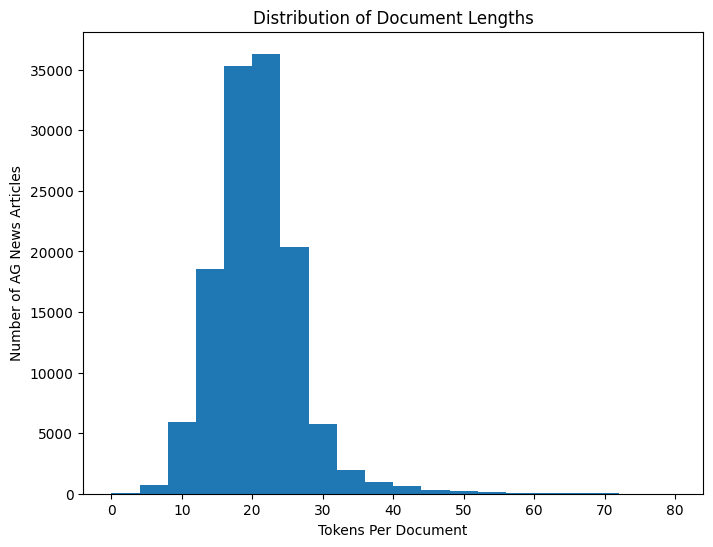

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(doc_sizes, bins=20,range = (0,80))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles")
plt.title("Distribution of Document Lengths")
plt.show()

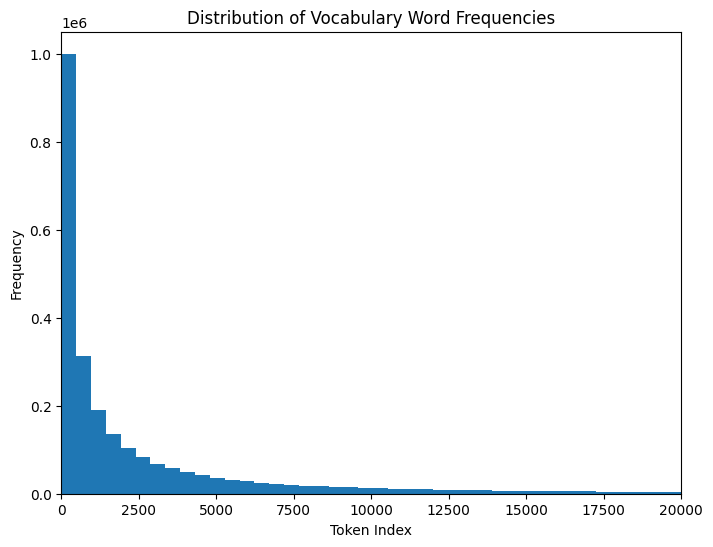

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(corpus, bins=200)
plt.xlabel("Token Index")
plt.ylabel("Frequency")
plt.title("Distribution of Vocabulary Word Frequencies")
plt.xlim(0, 20000)
plt.show()

In [ ]:
# Check the vectorized text, 5 examples
for text, label in dataset_all.take(5):
  vectorized_text = text_vectorization(text)
  print(f"Original text: {text.numpy()}")
  print(f"Vectorized text: {vectorized_text.numpy()}")
  print("-" * 20)

Original text: b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
Vectorized text: [1580    2    4 4038 5740  598  636 4754  591 1593  859  169 8056  160
  148  238 5908]
--------------------
Original text: b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
Vectorized text: [    6    98    82 87887    49   374  1340   617   276 83203   556  7344
  3193  2775  4736 48146   482    52]
--------------------
Original text: b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.'
Vectorized text: [   23   118     2 62190    37   627  2591  1338  8009  4066  3172    32
  1797

In [ ]:
# Create model for saving the text_vectorization layer
vectorize_layer_model_full = tf.keras.models.Sequential()
vectorize_layer_model_full.add(tf.keras.Input(shape=(1,), dtype=tf.string))
vectorize_layer_model_full.add(text_vectorization)
vectorize_layer_model_full.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vectorize_layer_model_full.save('vectorize_layer_model_full.keras')

In [ ]:
loaded_vectorize_layer_model = tf.keras.models.load_model('vectorize_layer_model_full.keras')

In [ ]:
vectorize_layer_full = loaded_vectorize_layer_model.layers[0]
# tested this layer and it performed the same

In [ ]:
vocab = np.array(vectorize_layer_full.get_vocabulary())

### Change max_tokens
If the input text data contains more unique tokens than the specified max_tokens, the layer will prioritize the most frequent tokens to populate its vocabulary. Less frequent tokens will be excluded.

Tokens not included in the vocabulary will typically be treated as "out-of-vocabulary" (OOV) tokens and mapped to a special OOV index, usually 1, if output_mode is set to 'int'.

Limiting max_tokens can be crucial when working with large datasets and potentially vast vocabularies, as it helps manage memory usage and computational resources.

In [ ]:
%%time
max_tokens = 3000
text_vectorization=layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_dataset_all)

CPU times: user 15min 3s, sys: 9.63 s, total: 15min 13s
Wall time: 14min 56s


In [ ]:
vocab = np.array(text_vectorization.get_vocabulary())
print(vocab[:100]) # sorted by frequency

['' '[UNK]' '39s' 'said' 'new' 'us' 'reuters' 'ap' 'two' 'first' 'monday'
 'wednesday' 'tuesday' 'thursday' 'company' 'friday' 'inc' 'one' 'world'
 'yesterday' 'last' 'york' 'year' 'president' 'million' 'oil' 'corp'
 'united' 'would' 'sunday' 'years' 'week' 'people' 'today' 'three'
 'government' 'could' 'quot' 'group' 'time' 'percent' 'game' 'saturday'
 'software' 'night' 'next' 'prices' 'iraq' 'security' 'announced'
 'minister' 'microsoft' 'season' 'team' 'second' 'internet'
 'international' 'may' 'washington' 'state' '2004' 'former' 'states' '39'
 'officials' 'back' 'market' 'day' 'says' 'billion' 'win' 'business'
 'news' 'victory' 'city' 'four' 'european' 'top' 'afp' 'technology'
 'reported' 'service' 'league' 'sales' 'federal' 'killed' 'according'
 'computer' 'national' 'record' 'home' 'prime' 'american' 'plans' 'end'
 'third' 'made' 'research' 'major' 'network']


In [ ]:
# Check the vectorized text, 5 examples
for text, label in dataset_all.take(5):
  vectorized_text = text_vectorization(text)
  print(f"Original text: {text.numpy()}")
  print(f"Vectorized text: {vectorized_text.numpy()}")
  print("-" * 20)

Original text: b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
Vectorized text: [1580    2    4    1    1  598  636    1  591 1593  859  169    1  160
  148  238    1]
--------------------
Original text: b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
Vectorized text: [   6   98   82    1   49  374 1340  617  276    1  556    1    1 2775
    1    1  482   52]
--------------------
Original text: b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.'
Vectorized text: [  23  118    2    1   37  627 2591 1338    1    1    1   32 1797   84
    1   59  592 2418   57 

In [ ]:
# Create model for saving the text_vectorization layer
vectorize_layer_model_3000 = tf.keras.models.Sequential()
vectorize_layer_model_3000.add(tf.keras.Input(shape=(1,), dtype=tf.string))
vectorize_layer_model_3000.add(text_vectorization)
vectorize_layer_model_3000.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vectorize_layer_model_3000.save('vectorize_layer_model_3000.keras')

### add some of the frequent words in vocabulary to STOPWORDS

In [ ]:
vocab = np.array(vectorize_layer_3000.get_vocabulary())

In [ ]:
indices = list(range(2, 14)) + [15, 17] + list(range(19, 22)) + list(range(28, 32)) + [34, 36, 42, 44]
selected_words = [vocab.tolist()[i] for i in indices]

In [ ]:
selected_words

['39s',
 'said',
 'new',
 'us',
 'reuters',
 'ap',
 'two',
 'first',
 'monday',
 'wednesday',
 'tuesday',
 'thursday',
 'friday',
 'one',
 'yesterday',
 'last',
 'york',
 'would',
 'sunday',
 'years',
 'week',
 'three',
 'could',
 'saturday',
 'night']

In [ ]:
STOPWORDS.extend(selected_words)

In [ ]:
%%time
max_tokens = 5000
text_vectorization=layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_dataset_all)

CPU times: user 15min 46s, sys: 13.7 s, total: 16min
Wall time: 16min 3s


In [ ]:
# Check the vectorized text, 5 examples
for text, label in dataset_all.take(5):
  vectorized_text = text_vectorization(text)
  print(f"Original text: {text.numpy()}")
  print(f"Vectorized text: {vectorized_text.numpy()}")
  print("-" * 20)

Original text: b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
Vectorized text: [1556 4014    1  574  612 4730  567 1569  835  145    1  136  124  214
    1]
--------------------
Original text: b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
Vectorized text: [  74   58    1   25  350 1316  593  252    1  532    1 3169 2751 4712
    1  458   28]
--------------------
Original text: b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.'
Vectorized text: [   7   94    1   15  603 2567 1314    1 4042 3148   12 1773   60    1
   35  568 2394   33  517    1   39    1 

In [ ]:
# Create model for saving the text_vectorization layer
vectorize_layer_model_5000_add_stop = tf.keras.models.Sequential()
vectorize_layer_model_5000_add_stop.add(tf.keras.Input(shape=(1,), dtype=tf.string))
vectorize_layer_model_5000_add_stop.add(text_vectorization)
vectorize_layer_model_5000_add_stop.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vectorize_layer_model_5000_add_stop.save('vectorize_layer_model_5000_add_stop.keras')

### Use max_tokens=5000 without added stop words for comparison

In [ ]:
%%time
max_tokens = 5000
text_vectorization=layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_dataset_all)

CPU times: user 15min 13s, sys: 9.71 s, total: 15min 23s
Wall time: 15min 7s


In [ ]:
# Check the vectorized text, 5 examples
for text, label in dataset_all.take(5):
  vectorized_text = text_vectorization(text)
  print(f"Original text: {text.numpy()}")
  print(f"Vectorized text: {vectorized_text.numpy()}")
  print("-" * 20)

Original text: b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
Vectorized text: [1580    2    4 4038    1  598  636 4754  591 1593  859  169    1  160
  148  238    1]
--------------------
Original text: b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
Vectorized text: [   6   98   82    1   49  374 1340  617  276    1  556    1 3193 2775
 4736    1  482   52]
--------------------
Original text: b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.'
Vectorized text: [  23  118    2    1   37  627 2591 1338    1 4066 3172   32 1797   84
    1   59  592 2418   57 

In [ ]:
# Create model for saving the text_vectorization layer
vectorize_layer_model_5000 = tf.keras.models.Sequential()
vectorize_layer_model_5000.add(tf.keras.Input(shape=(1,), dtype=tf.string))
vectorize_layer_model_5000.add(text_vectorization)
vectorize_layer_model_5000.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vectorize_layer_model_5000.save('vectorize_layer_model_5000.keras')

### Use max_tokens=10000 without added stop words for comparison

In [ ]:
%%time
max_tokens = 10000
text_vectorization=layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_dataset_all)

CPU times: user 14min 18s, sys: 12.2 s, total: 14min 30s
Wall time: 13min 56s


In [ ]:
# Check the vectorized text, 5 examples
for text, label in dataset_all.take(5):
  vectorized_text = text_vectorization(text)
  print(f"Original text: {text.numpy()}")
  print(f"Vectorized text: {vectorized_text.numpy()}")
  print("-" * 20)

Original text: b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
Vectorized text: [1580    2    4 4038 5740  598  636 4754  591 1593  859  169 8056  160
  148  238 5908]
--------------------
Original text: b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
Vectorized text: [   6   98   82    1   49  374 1340  617  276    1  556 7344 3193 2775
 4736    1  482   52]
--------------------
Original text: b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.'
Vectorized text: [  23  118    2    1   37  627 2591 1338 8009 4066 3172   32 1797   84
    1   59  592 2418   57 

In [ ]:
# Create model for saving the text_vectorization layer
vectorize_layer_model_10000 = tf.keras.models.Sequential()
vectorize_layer_model_10000.add(tf.keras.Input(shape=(1,), dtype=tf.string))
vectorize_layer_model_10000.add(text_vectorization)
vectorize_layer_model_10000.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vectorize_layer_model_10000.save('vectorize_layer_model_10000.keras')

### Experiment1: Test different indexing method with a simple RNN model

In [ ]:
dataset, info = tfds.load('ag_news_subset', with_info=True, split=['train[:90%]', 'train[90%:]', 'test'], batch_size=64, as_supervised=True)

train_ds, val_ds, test_ds = dataset

# Verify class balance in the new splits
def check_class_balance(ds, name, info):
    labels = [label.numpy() for _, label in ds.unbatch()]
    categories = dict(enumerate(info.features["label"].names))
    class_counts = Counter([categories[label] for label in labels])
    print(f"Class distribution in {name} dataset:")
    print(class_counts.most_common())

check_class_balance(train_ds, "training", info)
check_class_balance(val_ds, "validation", info)
check_class_balance(test_ds, "test", info)

Class distribution in training dataset:
[('Business', 27081), ('Sci/Tech', 27019), ('Sports', 26985), ('World', 26915)]
Class distribution in validation dataset:
[('World', 3085), ('Sports', 3015), ('Sci/Tech', 2981), ('Business', 2919)]
Class distribution in test dataset:
[('Sports', 1900), ('World', 1900), ('Sci/Tech', 1900), ('Business', 1900)]


In [ ]:
loaded_vectorize_layer_model = tf.keras.models.load_model('vectorize_layer_model_3000.keras')
vectorize_layer_3000 = loaded_vectorize_layer_model.layers[0]

In [ ]:
int_train_ds = train_ds.map(
    lambda x, y: (vectorize_layer_3000(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (vectorize_layer_3000(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (vectorize_layer_3000(x), y),
    num_parallel_calls=4)

In [ ]:
max_tokens=len(vectorize_layer_3000.get_vocabulary())

inputs = keras.Input(shape=(None, ), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=256
                            ,mask_zero=True)(inputs)
x = layers.SimpleRNN(16)(embedded)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, None, 256) │    768,000 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, None)      │          0 │ input_layer_8[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_5        │ (None, 16)        │      4,368 │ embedding_5[0][0… │
│ (SimpleRNN)         │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4)         │         68 │ simple_rnn_5[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 772,436 (2.95 MB)

 Trainable params: 772,436 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("test_RNN.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("test_RNN.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 72s 40ms/step - accuracy: 0.7110 - loss: 0.7193 - val_accuracy: 0.8737 - val_loss: 0.3847
Epoch 2/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 69s 41ms/step - accuracy: 0.8834 - loss: 0.3472 - val_accuracy: 0.8706 - val_loss: 0.3782
Epoch 3/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - accuracy: 0.9054 - loss: 0.2863 - val_accuracy: 0.8687 - val_loss: 0.3983
Epoch 4/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 67s 40ms/step - accuracy: 0.9207 - loss: 0.2428 - val_accuracy: 0.8612 - val_loss: 0.4384
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8749 - loss: 0.3827
Test acc: 0.874
CPU times: user 6min 35s, sys: 10.3 s, total: 6min 46s
Wall time: 4min 51s


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
0,0.812,0.522,0.874,0.385
1,0.889,0.332,0.871,0.378
2,0.909,0.276,0.869,0.398
3,0.923,0.237,0.861,0.438


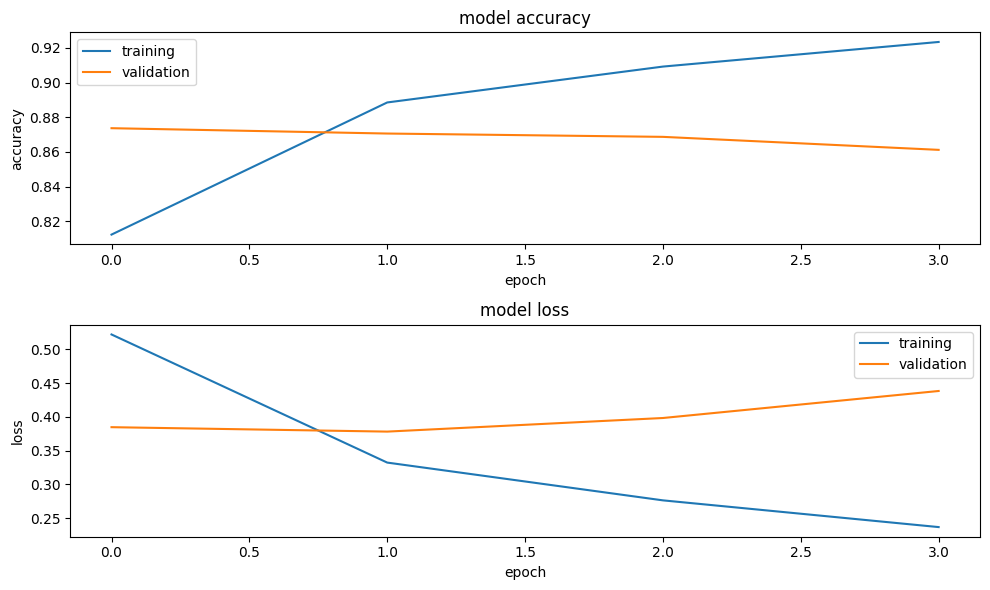

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1900
           1       0.92      0.96      0.94      1900
           2       0.81      0.87      0.84      1900
           3       0.86      0.81      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.88      0.87      0.87      7600
weighted avg       0.88      0.87      0.87      7600

Accuracy Score: 0.8743421052631579
Root Mean Square Error: 0.6103277807866851


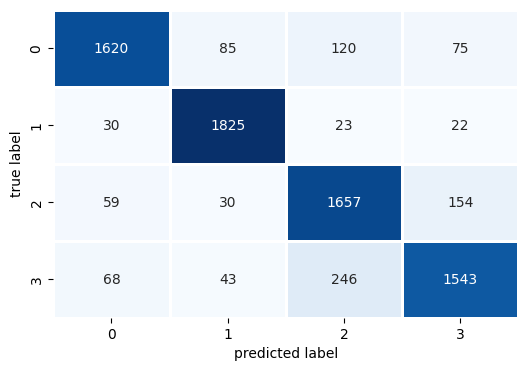

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
loaded_vectorize_layer_model = tf.keras.models.load_model('vectorize_layer_model_5000.keras')
vectorize_layer_5000 = loaded_vectorize_layer_model.layers[0]

In [ ]:
int_train_ds = train_ds.map(
    lambda x, y: (vectorize_layer_5000(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (vectorize_layer_5000(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (vectorize_layer_5000(x), y),
    num_parallel_calls=4)

In [ ]:
max_tokens=len(vectorize_layer_5000.get_vocabulary())

inputs = keras.Input(shape=(None, ), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=256
                            ,mask_zero=True)(inputs)
x = layers.SimpleRNN(16)(embedded)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, None, 256) │  1,280,000 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, None)      │          0 │ input_layer_9[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_6        │ (None, 16)        │      4,368 │ embedding_6[0][0… │
│ (SimpleRNN)         │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │         68 │ simple_rnn_6[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,284,436 (4.90 MB)

 Trainable params: 1,284,436 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("test_RNN.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("test_RNN.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 80s 45ms/step - accuracy: 0.7752 - loss: 0.6109 - val_accuracy: 0.8811 - val_loss: 0.3640
Epoch 2/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - accuracy: 0.8985 - loss: 0.3116 - val_accuracy: 0.8807 - val_loss: 0.3572
Epoch 3/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 78s 45ms/step - accuracy: 0.9246 - loss: 0.2367 - val_accuracy: 0.8771 - val_loss: 0.3942
Epoch 4/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 75s 44ms/step - accuracy: 0.9333 - loss: 0.2107 - val_accuracy: 0.8694 - val_loss: 0.4295
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8831 - loss: 0.3599
Test acc: 0.881
CPU times: user 7min 26s, sys: 10.6 s, total: 7min 36s
Wall time: 5min 13s


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
0,0.846,0.457,0.881,0.364
1,0.904,0.296,0.881,0.357
2,0.929,0.224,0.877,0.394
3,0.918,0.254,0.869,0.430


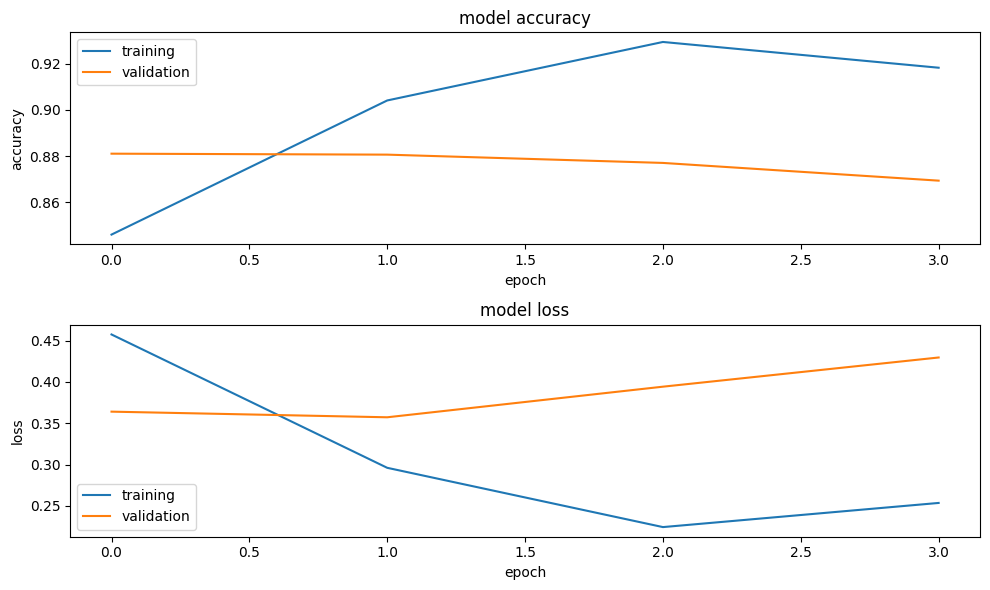

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1900
           1       0.94      0.96      0.95      1900
           2       0.82      0.87      0.84      1900
           3       0.87      0.82      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.8811842105263158
Root Mean Square Error: 0.5920526292395581


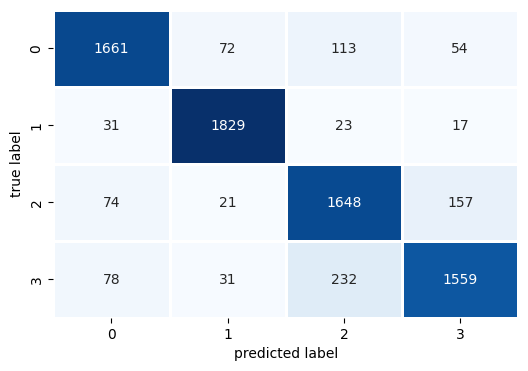

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
loaded_vectorize_layer_model = tf.keras.models.load_model('vectorize_layer_model_5000_add_stop.keras')
vectorize_layer_5000_add_stop = loaded_vectorize_layer_model.layers[0]

In [ ]:
int_train_ds = train_ds.map(
    lambda x, y: (vectorize_layer_5000_add_stop(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (vectorize_layer_5000_add_stop(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (vectorize_layer_5000_add_stop(x), y),
    num_parallel_calls=4)

In [ ]:
max_tokens=len(vectorize_layer_5000_add_stop.get_vocabulary())

inputs = keras.Input(shape=(None, ), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=256
                            ,mask_zero=True)(inputs)
x = layers.SimpleRNN(16)(embedded)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, None, 256) │  1,280,000 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_9         │ (None, None)      │          0 │ input_layer_10[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_7        │ (None, 16)        │      4,368 │ embedding_7[0][0… │
│ (SimpleRNN)         │                   │            │ not_equal_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 4)         │         68 │ simple_rnn_7[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,284,436 (4.90 MB)

 Trainable params: 1,284,436 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("test_RNN.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("test_RNN.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 78s 45ms/step - accuracy: 0.7463 - loss: 0.6747 - val_accuracy: 0.8702 - val_loss: 0.3973
Epoch 2/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.8874 - loss: 0.3438 - val_accuracy: 0.8677 - val_loss: 0.3984
Epoch 3/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 79s 44ms/step - accuracy: 0.9166 - loss: 0.2638 - val_accuracy: 0.8548 - val_loss: 0.4524
Epoch 4/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 76s 45ms/step - accuracy: 0.9335 - loss: 0.2113 - val_accuracy: 0.8507 - val_loss: 0.4979
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8666 - loss: 0.3949
Test acc: 0.866
CPU times: user 7min 20s, sys: 10.5 s, total: 7min 31s
Wall time: 5min 17s


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
0,0.831,0.501,0.870,0.397
1,0.894,0.326,0.868,0.398
2,0.922,0.251,0.855,0.452
3,0.935,0.209,0.851,0.498


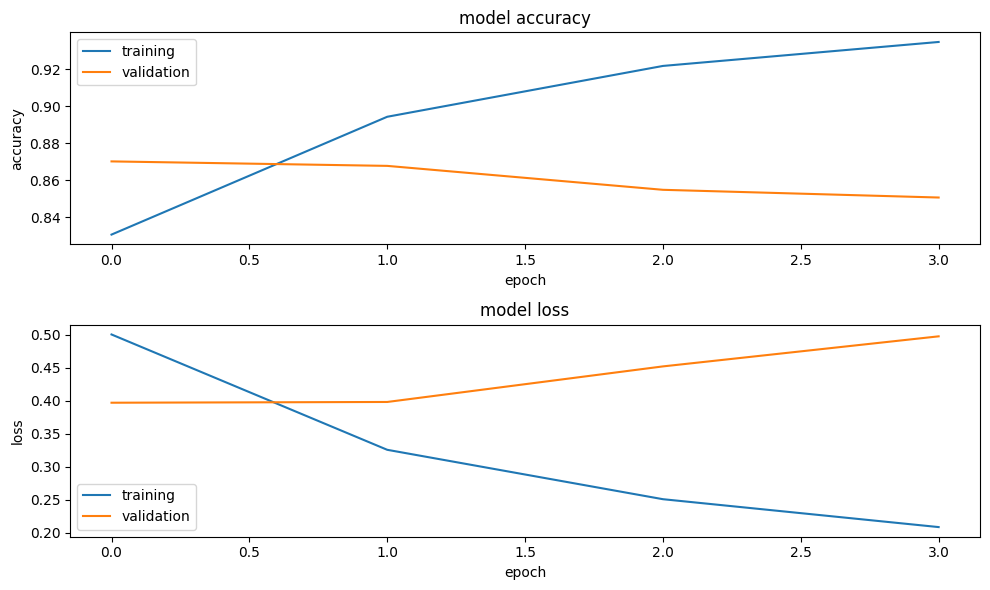

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1900
           1       0.92      0.96      0.94      1900
           2       0.80      0.85      0.82      1900
           3       0.87      0.79      0.83      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600

Accuracy Score: 0.8664473684210526
Root Mean Square Error: 0.6109742005062165


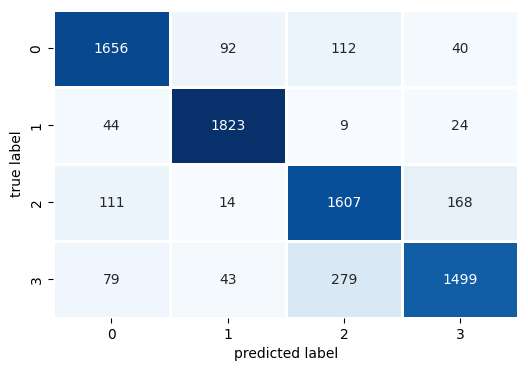

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
loaded_vectorize_layer_model = tf.keras.models.load_model('vectorize_layer_model_10000.keras')
vectorize_layer_model_10000 = loaded_vectorize_layer_model.layers[0]

In [ ]:
int_train_ds = train_ds.map(
    lambda x, y: (vectorize_layer_model_10000(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (vectorize_layer_model_10000(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (vectorize_layer_model_10000(x), y),
    num_parallel_calls=4)

In [ ]:
max_tokens=len(vectorize_layer_3000.get_vocabulary())

inputs = keras.Input(shape=(None, ), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=256
                            ,mask_zero=True)(inputs)
x = layers.SimpleRNN(16)(embedded)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  2,560,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn          │ (None, 16)        │      4,368 │ embedding[0][0],  │
│ (SimpleRNN)         │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │         68 │ simple_rnn[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,564,436 (9.78 MB)

 Trainable params: 2,564,436 (9.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("test_RNN.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("test_RNN.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 94s 54ms/step - accuracy: 0.7250 - loss: 0.6757 - val_accuracy: 0.8782 - val_loss: 0.3764
Epoch 2/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 99s 59ms/step - accuracy: 0.9032 - loss: 0.3044 - val_accuracy: 0.8733 - val_loss: 0.3964
Epoch 3/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 87s 52ms/step - accuracy: 0.9392 - loss: 0.2031 - val_accuracy: 0.8620 - val_loss: 0.4731
Epoch 4/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 84s 49ms/step - accuracy: 0.9543 - loss: 0.1548 - val_accuracy: 0.8561 - val_loss: 0.5281
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8785 - loss: 0.3748
Test acc: 0.876
CPU times: user 9min 7s, sys: 10.1 s, total: 9min 17s
Wall time: 6min 7s


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
0,0.825,0.495,0.878,0.376
1,0.912,0.281,0.873,0.396
2,0.944,0.190,0.862,0.473
3,0.957,0.147,0.856,0.528


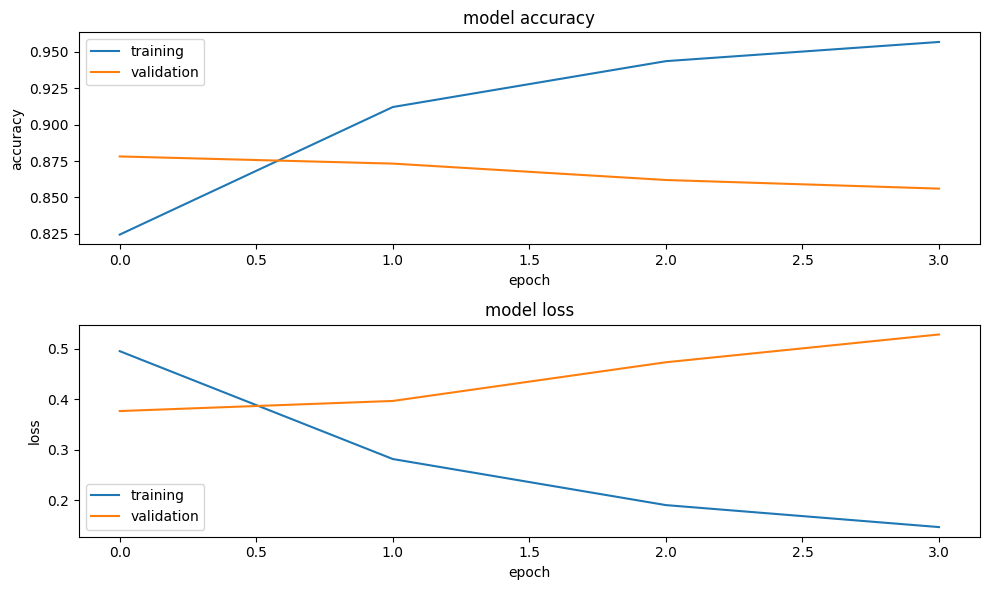

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.85      0.88      1900
           1       0.93      0.96      0.95      1900
           2       0.80      0.87      0.83      1900
           3       0.86      0.83      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.8761842105263158
Root Mean Square Error: 0.5761715753232941


In [ ]:
# Time Stamp
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

# Print the formatted time
print("Last Run:", formatted_time)

In [4]:
!jupyter nbconvert --to html 'MSDS458_Assignment3_part1_EDA_mao.ipynb'

[NbConvertApp] Converting notebook MSDS458_Assignment3_part1_EDA_mao.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_core/application.py", line 284, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 563, in convert_single_notebook
    output, resources = self.export_single_notebook(
                        ^^^^^^^^^^^^^^^^^^^^^